<img src="images/ublogo.png"/>

### CSE610 - Bayesian Non-parametric Machine Learning

  - Lecture Notes
  - Instructor - Varun Chandola
  - Term - Fall 2020

### Objective
The objective of this notebook is to provide detailed discussions about using Gaussian Processes (GP) for classification problems.

<div class="alert alert-info">

**Note:** This material is based on Chapter 3 of the GPML book.

</div>

We now turn out attention to *classification* problems, where the target is not real, but categorical, i.e., $y \in \{C_1,C_2,\ldots,C_\mathcal{C}\}$, where $\mathcal{C}$ is the number of possible classes that the target can be in. We will work with probabilistic classification, where we are interested in:
$$
P(Y = C_1\vert X = {\bf x})
$$
> There are two general approaches to building probabilistic classifiers. One is to start with the joint probability distribution, $p({\bf x},y)$, which can be decomposed as $p({\bf x}\vert y)p(y)$ and then use *Bayes rule* to get $p(y\vert{\bf x})$. The other is to directly model $p(y\vert {\bf x})$ without making any assumptions about $p({\bf x})$. The former approach is called **generative models** and the latter approach is called **discriminative models**. 

<div class="alert alert-warning">
Gaussian process classification is discriminative.
</div>

We will see that, to a certain extent, applying GP to probabilistic classification is similar to applying GP to regression, as we saw earlier. However, the problem is much more demanding due to one key reason: *the likelihood function in a classification setting cannot be Gaussian*. This leads to a challenging issue that requires approximate solutions.

### Linear logistic regression model
Consider a binary classification setting, i.e., the targets can either be $+1$ or $-1$. In the logistic regression model, we directly model the conditional probability for the targets, as follows:
$$
p(y = +1 \vert {\bf x},{\bf w}) = \sigma({\bf w}^\top{\bf x})
$$
> $\sigma(\cdot)$ can be any *sigmoid* function, which is any monotonically increasing function from $\mathbb{R} \rightarrow [0,1]$. 

> A popular choice for $\sigma(\cdot)$ is the *logistic response function*, such that $\sigma(z) = \frac{1}{1 + \exp{-z}}$, in which case the classification model is called **linear logistic regression** (or just **logistic regression**).

> However, there are other possible choices as well. For instance, the **linear probit regression** model uses the probit function, which is the cumulative density of a standard normal distribution, i.e., $\sigma(z) = \int_{-\infty}^z\mathcal{N}(u\vert 0,1)du$

<div class="alert alert-info">
    
**Note:** For the subsequent discussions, we will use the logistic function as the response function.

</div>

Using this model, we can get the probability of $y$ to be any one of the labels:
$$
p(y = +1 \vert {\bf x},{\bf w}) = \sigma({\bf w}^\top{\bf x})\text{;   } p(y = -1 \vert {\bf x},{\bf w}) = 1 - p(y = +1 \vert {\bf x},{\bf w}) = \sigma(-{\bf w}^\top{\bf x})
$$

The above result uses the fact that the logistic function is symmetric, i.e., $1 - \sigma(z) = \sigma(-z)$.

Thus, if we are given a training data set, $\mathcal{D} = \{({\bf x}_i,y_i)\vert i = 1,\ldots,N\}$, the probability of the $i^{th}$ label is given by:
$$
p(y_i\vert {\bf x}_i,{\bf w}) = \sigma(y_i{\bf w}^\top{\bf x}_i)
$$

#### The non-Bayesian formulation of logistic regression
To learn the optimal weights, ${\bf w}$, one can calculate the log-likelihood of the training data set, i.e., 
$$
\mathcal{L}(\mathcal{D}\vert {\bf w}) = \sum_{i=1}^N \log{\sigma(y_i{\bf w}^\top{\bf x}_i})
$$
and then find the ${\bf w}$ that maximizes the log-likelihood. This can be done using a gradient based optimizer.

#### The Bayesian formulation of logistic regression
Assuming a Gaussian prior on ${\bf w}$, i.e., ${\bf w} \sim \mathcal{N}({\bf 0},\Sigma_p)$, the posterior distribution for ${\bf w}$ will be:
$$
p({\bf w}\vert \mathcal{D}) = \frac{p(\mathcal{D}\vert{\bf w})p({\bf w})}{\int p(\mathcal{D}\vert{\bf w}')p({\bf w}')d{\bf w}'}
$$

Now, this is the start of all our troubles :(


For linear regression, the posterior for ${\bf w}$ was also a Gaussian. However, we do not get a similar simple analytical form here.

If we ignore the denominator, we can calculate the *unnormalized* log posterior for ${\bf w}$ as:
$$
\log{p({\bf w}\vert \mathcal{D})} \stackrel{c}{=} -\frac{1}{2}{\bf w}^\top \Sigma_p{\bf w} + \sum_{i=1}^N \log{\sigma(y_i{\bf w}^\top{\bf x}_i)}
$$
We can maximize the above unnormalized log posterior and get the MAP estimate for ${\bf w}$ (The objective function is indeed a nice concave function, and one can use a gradient based optimizer, e.g., *Newtons's method* to get the MAP estimate.).

#### Example:
Consider a 2-D data set and a binary classification problem. We are interested in learning a weight vector, ${\bf w}$ that can be used to assign the probability of a test instance to belong to class $+1$ or $-1$. For the sake of visualization, we will ignore the intercept term and assume that ${\bf w}$ is two-dimensional.

We first define a Gaussian prior on ${\bf w}$.


In [150]:
%run Utilities.ipynb

In [7]:
prior_mean = np.zeros((2,))
prior_cov = np.eye(2)

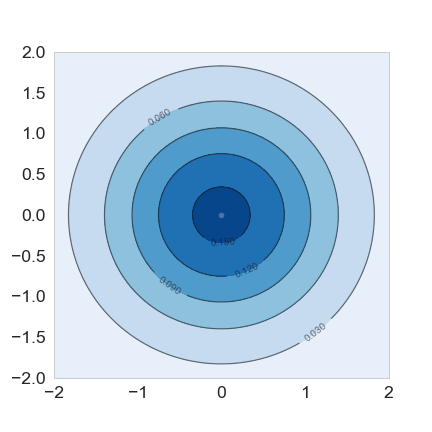

In [10]:
# plot the prior distribution
fig = plt.figure(figsize=(6,6))
ax = fig.gca()

plot_contours(ax,prior_mean,prior_cov,limits=(-2,2),levels=5,cm='Blues')
ax.scatter(prior_mean[0],prior_mean[1])

Next we consider a small training set:

In [11]:
X = np.array([
    [-5,1],
    [1,0],
    [-1,-5],
    [-0.5,-0.5],
    [1,5],
    [5,4]
])
y = np.array([-1,-1,-1,+1,+1,+1])

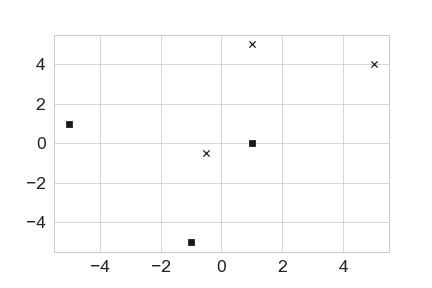

In [17]:
plt.scatter(X[0:3,0],X[0:3,1],c='k',marker='s',s=40)
plt.scatter(X[3:,0],X[3:,1],c='k',marker='x',s=40)

Next we plot the posterior pdf for ${\bf w}\vert X,{\bf y}$. But we do not have an analytical form for that. However, we can compute the unnormalized log pdf (as shown above) and visualize that.

In [38]:
def logpdf(w,X,y,Sigma_p):
    f = np.dot(X,w)
    return -0.5*np.dot(w.T,np.linalg.solve(Sigma_p,w)) + np.sum(1/(1 + np.exp(-y[:,np.newaxis]*f)))

In [51]:
# compute the objective function for a range of values for w and w0
w1s = np.linspace(-2, 2, 40)
w2s = np.linspace(-2, 2, 40)
W1, W2 = np.meshgrid(w1s, w2s)
logpdfs = []
for w1,w2 in zip(W1.flatten(),W2.flatten()):
    logpdfs.append(logpdf(np.array([[w1],[w2]]),X,y,prior_cov))

logpdfs = np.array(logpdfs)
L = np.reshape(logpdfs,(len(w1s),len(w2s)))    

<a list of 22 text.Text objects>

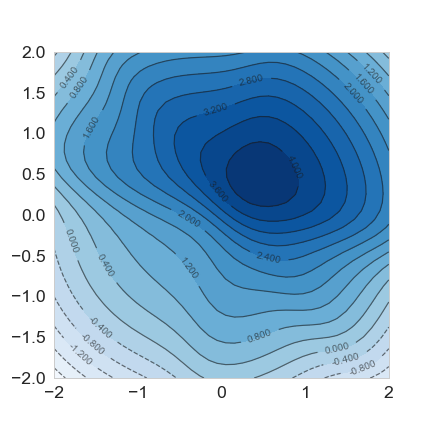

In [52]:
fig = plt.figure(figsize=(6,6))
ax = fig.gca()

cfset = ax.contourf(W1, W2, L, levels=20,cmap='Blues')
cset = ax.contour(W1, W2, L, levels=20, colors='k',alpha=0.6)
ax.clabel(cset, inline=1, fontsize=10)

Note how the unnormalized pdf above is not Gaussian. How can we get the posterior predictive distribution for a new test instance, ${\bf x}_*$?
$$
p(y_* = 1\vert {\bf x}_*,X,{\bf y}) = \int p(y_* = 1\vert {\bf w},{\bf x}_*)p({\bf w}\vert X,{\bf y})d{\bf w}
$$
Since the posterior pdf of ${\bf w}$ is not a *well-behaved* function, the above integral is tough to calculate. In fact, we cannot even sample ${\bf w}$s from the posterior to do Monte-carlo sampling.

A pain-staking way to *build* the predictive distribution would be to do a numeric integration over the entire grid.

In [57]:
def predictiveProb(x_star,X,y,Sigma_p):
    w1s = np.linspace(-2, 2, 40)
    w2s = np.linspace(-2, 2, 40)
    W1, W2 = np.meshgrid(w1s, w2s)
    pred_prob = 0
    for w1,w2 in zip(W1.flatten(),W2.flatten()):
        w = np.array([[w1],[w2]])
        pdf = np.exp(logpdf(w,X,y,prior_cov))
        pred_w = 1/(1 + np.exp(-1*np.dot(w.T,x_star)))
        pred_prob += pdf*pred_w
    return pred_prob


In [67]:
x1s = np.linspace(-6, 6, 40)
x2s = np.linspace(-6, 6, 40)
X1, X2 = np.meshgrid(x1s, x2s)
pred_probs = []
for x1,x2 in zip(X1.flatten(),X2.flatten()):
    pred_probs.append(predictiveProb(np.array([[x1],[x2]]),X,y,prior_cov))

pred_probs = np.array(pred_probs)
P = np.reshape(pred_probs,(len(x1s),len(x2s)))    

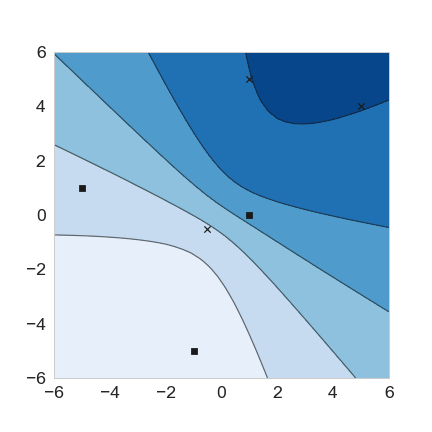

In [68]:
fig = plt.figure(figsize=(6,6))
ax = fig.gca()

cfset = ax.contourf(X1, X2, P, levels=5,cmap='Blues')
cset = ax.contour(X1, X2, P, levels=5, colors='k',alpha=0.6)
ax.scatter(X[0:3,0],X[0:3,1],c='k',marker='s',s=40)
ax.scatter(X[3:,0],X[3:,1],c='k',marker='x',s=40)
#ax.clabel(cset, inline=1, fontsize=10)

### Gaussian Process Classification
The basic idea of using GP for classification is similar to the regression setting - we place a GP prior over the the *latent function*, $f({\bf x})$, and then "squash" this through the logistic function to obtain a prior on:
$$
\pi({\bf x}) \triangleq p(y = +1\vert {\bf x}) = \sigma(f({\bf x}))
$$
> We have introduced a new notation, we are using the function $\pi({\bf x})$ to denote the probability of the class to be +1, for a given ${\bf x}$ - this is just a short-cut notation. $\pi()$ is a deterministic function of $f()$, and since $f()$ is a stochastic function (sampled from the GP prior), so will be $\pi()$

> You can draw parallels between GPR and GPC. In GPR, we assumed that the observation, $y$, was connected to $f({\bf x})$ through $y = f({\bf x}) + \epsilon, \epsilon \sim \mathcal{N}(0,\sigma_n^2)$. Here, $\pi({\bf x})$ is conected to $f({\bf x})$ through $\pi({\bf x}) = f({\bf x})$. Notice that for GPC we assume a *noise-free* relationship.

#### Obtaining predictive distribution for a test instance
The inference in GPC is divided into 2 steps:

First, find the distribution of the latent function, for the given test case:
$$
p(f_* \vert X,{\bf y},{\bf x}_*) = \int p(f_*\vert X,{\bf x}_*,{\bf f})p({\bf f}\vert X,{\bf y})d{\bf f}
$$
The first term is given to us through the GP prior (*recall*: the conditional on a new test instance, will be a Gaussian). The second term is the probability of obtaining a given latent function, given the training data:
$$
p({\bf f}\vert X,{\bf y}) = \frac{p({\bf y}\vert {\bf f})p({\bf f}\vert X)}{p({\bf y}\vert X)}
$$

Second, use the distribution over the latent $f_*$ to produce a probabilistic prediction:
$$
\bar{\pi}_* \triangleq p(y_* = +1 \vert X,{\bf y},{\bf x}_*) = \int \sigma(f_*)p(f_*\vert X,{\bf y},{\bf x}_*)df_*
$$

#### Computational tractability issues
The integral in (10) is analytically intractable, due to the non-Gaussian probability distribution, $p({\bf y}\vert {\bf f},X)$. The integral in (11) is generally interactable, though one can do a simple numerical integration (at least for the binary classification case). 

### Approximate inference methods
1. `Monte carlo sampling`
2. `Laplace approximation`
3. `Expectation Propagation`

Here we will discuss the latter two methods.

### Laplace Approximation for Binary GP Classification
The general idea is to approximate the posterior $p({\bf f}\vert X,{\bf y})$ with a Gaussian approximation, $q({\bf f}\vert X, {\bf y})$.  Once we have $q()$, we can plug that into (10) above, and get a Gaussian posterior for $p(f_* \vert X,{\bf y},{\bf x}_*)$. 

The strategy behind Laplace's method is:
- Consider the log-posterior expression, i.e., $\log{p({\bf f}\vert X,{\bf y})}$
> Question: Is this known?
- Find the value of ${\bf f}$ at which the above log-posterior is maximum - $\hat{\bf f}$
- Do a second order Taylor series expansion of $\log{p({\bf f}\vert X,{\bf y})}$ around $\hat{\bf f}$
- Obtain the Gaussian approximation:
$$
q({\bf f}\vert X, {\bf y}) = \mathcal{N}(\hat{\bf f},A^{-1})
$$

> If you look at the log-posterior of a Gaussian distribution (say, ${\bf z} \sim \mathcal{N}({\bf \mu},\Sigma)$), it has the following form: 
$$
\log{p({\bf z})} = -\frac{1}{2}({\bf z}-{\bf \mu})^\top\Sigma^{-1}({\bf z}-{\bf \mu})-\frac{1}{2}\log{\vert \Sigma\vert}-\frac{N}{2}\log{2\pi} 
$$
So if we can approxiate the log pdf of any distribution to the above form, then we can approximate the distribution with a Gaussian distribution.


We will now see how to get $\hat{\bf f}$ and $A$

#### Posterior
Recall that the posterior distribution, $p({\bf f}\vert X,{\bf y})$ is given by:
$$
p({\bf f}\vert X,{\bf y}) = \frac{p({\bf y}\vert {\bf f})p({\bf f}\vert X)}{p({\bf y}\vert X)}
$$
but the denominator is independent of ${\bf f}$ so we can ignore it, when maximizing w.r.t. ${\bf f}$.

Or the log-posterior can be written as:
\begin{eqnarray}
\Psi({\bf f}) & \triangleq & \log{p({\bf y}\vert {\bf f})} + \log{p({\bf f}\vert X)}\\
              & =          & \log{p({\bf y}\vert {\bf f})} - \frac{1}{2}{\bf f}^\top K^{-1}{\bf f} - \frac{1}{2}\log{\vert K\vert} - \frac{N}{2}\log{2\pi}
\end{eqnarray}

Remember that $p({\bf y}\vert{\bf f}) = \prod_i\sigma(y_if_i)$, assuming that the data is i.i.d. However, we will not subsitute it yet in the above equation.

Let $\hat{{\bf f}}$ be the value of ${\bf f}$ at which $\Psi({\bf f})$ is maximum, i.e., $\nabla \Psi(\hat{{\bf f}}) = {\bf 0}$.

The *Taylor's series expansion* of $\Psi({\bf f})$ around $\hat{{\bf f}}$ will be:
$$
\Psi({\bf f}) \approx \Psi(\hat{{\bf f}}) + \nabla\Psi(\hat{{\bf f}})({\bf f}-\hat{{\bf f}}) + \frac{1}{2}({\bf f}-\hat{{\bf f}})^\top \nabla^2\Psi(\hat{\bf f})({\bf f}-\hat{{\bf f}})
$$
Here we are ignoring higher-order terms beyond 2. The second term will disappear because $\nabla \Psi(\hat{{\bf f}}) = {\bf 0}$. Which means that the log posterior can be approximated as:
$$
\Psi({\bf f}) \approx \Psi(\hat{{\bf f}}) + \frac{1}{2}({\bf f}-\hat{{\bf f}})^\top \nabla^2\Psi(\hat{\bf f})({\bf f}-\hat{{\bf f}})
$$
Thus, one can approximate the original $p({\bf f}\vert X,{\bf y})$ with a Gaussian distribution whose mean is $\hat{{\bf f}}$ and covariance matrix is $\nabla^2\Psi(\hat{\bf f})$. 



#### Obtaining $\hat{\bf f}$
This can be done by maximizing the objective function in (17) with respect to ${\bf f}$. This can be done using the *Newtons' method*, where you will need both the first order and second order derivatives: $\nabla\Psi(\hat{\bf f})$ and $\nabla^2\Psi(\hat{\bf f})$, respectively.

#### Obtaining $\nabla\Psi(\hat{\bf f})$:
By taking the gradient of $\Psi(\hat{\bf f})$, w.r.t, ${\bf f}$ in (17), we get:
\begin{equation}
\begin{aligned}
\nabla\Psi(\hat{\bf f}) & =  \nabla \log{p({\bf y}\vert{\bf f})} + \nabla \log{p({\bf f}\vert X)}\\
                        & = \nabla \log{p({\bf y}\vert{\bf f})} - K^{-1}{\bf f}
\end{aligned}
\end{equation}
> We have left the gradient of $p({\bf y}\vert{\bf f})$ "as is" for now.


#### Obtaining $\nabla^2\Psi(\hat{\bf f})$:
\begin{equation}
\begin{aligned}
\nabla^2\Psi(\hat{\bf f}) & = \nabla^2 \log{p({\bf y}\vert{\bf f})} - K^{-1}\\
 & = -W - K^{-1}
\end{aligned}
\end{equation}
where, $W = -\nabla^2 \log{p({\bf y}\vert{\bf f})}$ is a $N \times N$ matrix. Since we are operating under the assumption that the observed data is i.i.d., the matrix $W$ will be a diagonal matrix, whose $i^{th}$ diagonal term will be given by:
\begin{equation}
W_{ii} =  \frac{\partial^2}{\partial f_i^2} \log{p(y_i\vert f_i)}
\end{equation}
We know that $p(y_i\vert f_i) = \sigma(y_if_i) = \frac{1}{1+\exp{-y_if_i}}$. Here we are assuming that the sigmoid function is symmetric, i.e., $1 - \sigma(z) = \sigma(-z)$, which is the case with the *logistic* function. This gives us the following result:
\begin{equation}
\begin{aligned}
W_{ii} & =  \frac{\partial^2}{\partial f_i^2} \log{\frac{1}{1+\exp{-y_if_i}}}\\
       & =  \frac{\partial^2}{\partial f_i^2} -\log(1 + \exp{(-y_if_i)})\\
       & =  \frac{\partial}{\partial f_i}
       & \vdots \\
       & = -\pi_i(1 - \pi_i)
\end{aligned}
\end{equation}
where $\pi_i = p(y_i = 1\vert f_i)$

---
Replacing $p({\bf f}\vert X,{\bf y})$ (a non-Gaussian pdf) with a Gaussian $q({\bf f}\vert X,{\bf y}) \sim \mathcal{N}(\hat{\bf f},-W - K^{-1})$ in (10), we can now get revised estimate of the posterior distribution of $f_*$:
\begin{equation}
\begin{aligned}
p(f_* \vert X,{\bf y},{\bf x}_*) & = \int p(f_*\vert X,{\bf x}_*,{\bf f})p({\bf f}\vert X,{\bf y})d{\bf f}\\
                                 & \approx \int p(f_*\vert X,{\bf x}_*,{\bf f})q({\bf f}\vert X,{\bf y})d{\bf f}
\end{aligned}
\end{equation}
This is relatively easier to solve, since both terms have a Gaussian form. In fact, the posterior distribution for $f_*$ will also be Gaussian, with the mean and variance given by:
\begin{eqnarray}
\mathbb{E}[f_*\vert X,{\bf y},{\bf x}_*] & = & {\bf k}_*^\top K^{-1}\hat{{\bf f}}\\
var[f_*\vert X, {\bf y}, {\bf x}_*] & = & k({\bf x}_*,{\bf x}_*) - {\bf k}_*^\top (K+W^{-1})^{-1}{\bf k}_*
\end{eqnarray}

---
### Getting the prediction
Finally, how do we get the actual prediction ($p(y_* = +1 \vert X,{\bf y},{\bf x}_*)$ or $\pi_*$)?

There are two approaches here:
1. Take the expected value for $f_*$ from (25) and calculate the MAP prediction, $\hat{\pi}_* = \sigma(\mathbb{E}[f_*\vert X, {\bf y}, {\bf x}_*])$.
2. Do the Bayesian averaging:
$$
\bar{\pi}_* = \int \sigma(f_*)q(f_*\vert X, {\bf y}, {\bf x}_*) df_*
$$
where $q(f_*\vert X, {\bf y}, {\bf x}_*)$ is a Gaussian distribution with mean and variance given by (25) and (26), respectively.

It can be shown that if we are just interested in using the value of $\pi_*$ to assign the class to a test instance, both estimates will yield the same class label (either $+1$ or $-1$). However, if we want to get uncertainty associated with the prediction, we need to work with the Bayesian averaging method.

For certain sigmoid functions (e.g., the cumulative Gaussian or *probit*) one can analytically derive the expected value and the variance for $\pi_*$. However, for logistic function, this is not possible. Instead, one can use sampling based methods to get the expected value and the variance.
> Question: How will you use sampling to estimate the prediction and the variance associated with the prediction?

### Expectation Propagation
This is from Section 3.6 of the GPML book.

**Expectation Propagation** (or EP) is a general-purpose approximate inference scheme, proposed in 2000 by [Tom Minka](https://tminka.github.io/papers/ep/minka-ep-uai.pdf). Here we will only look at how EP can be used for GPC. 
<div class="alert alert-danger">
    <b>Note:</b> In the GPML book, the analyis of GPC with EP is done using the cumulative Gaussian sigmoid function. However, in this notebook we will continue using the logistic sigmoid function, to maintain continuity with previous discussion.
</div>

Just like with Laplace approximation, we will focus on the following *offending* pdf:
$$
p({\bf f}\vert X,{\bf y}) = \frac{p({\bf y}\vert {\bf f})p({\bf f}\vert X)}{p({\bf y}\vert X)}
$$
We are under the assumption that all observations, $y_i$ in the vector ${\bf y}$ are independent of each other. So the above distribution can be written as:
$$
p({\bf f}\vert X,{\bf y}) = \frac{1}{Z}p({\bf f}\vert X)\prod_{i=1}^N p(y_i\vert f_i)
$$
where the normalizing factor in the denominator, $Z$ is defined as:
$$
Z = p({\bf y}\vert X) = \int p({\bf f}\vert X)\prod_{i=1}^N p(y_i\vert f_i)
$$

The main issue here is that $p(y_i\vert f_i) = \sigma(f_i)$.


#### The EP approximation
The key idea in EP is to approximate $p(y_i\vert f_i)$ with an un-normalized Gaussian distribution, i.e., 
$$
p(y_i\vert f_i) = t_i(f_i \vert \tilde{Z}_i,\tilde{\mu}_i,\tilde{\sigma}_i^2) \triangleq \tilde{Z}_i\mathcal{N}(\tilde{\mu}_i,\tilde{\sigma}_i^2)
$$
where $\tilde{Z}_i,\tilde{\mu}_i,\tilde{\sigma}_i^2$ are called the unknown _site-parameters_
> We will talk about how to determine these site-parameters later. For now, let us assume that we have it.

The role of $\tilde{Z}_i$ is to ensure that the value of $t_i(f_i \vert \tilde{Z}_i,\tilde{\mu}_i,\tilde{\sigma}_i^2)$ is between 0 and 1, as it has to approximate a probability ($p(y_i\vert f_i)$).

We call the approximation in (31) as the _local likelihood approximation_. The product of these individual likelihoods will be:
$$
\prod_{i=1}^N t_i(f_i\vert \tilde{Z}_i,\tilde{\mu}_i,\tilde{\sigma}_i^2) =\mathcal{N}({\bf \tilde{\mu}},\tilde{\Sigma})\prod_{i=1}^N \tilde{Z}_i
$$
where ${\bf \tilde{\mu}}$ is a $N \times 1$ vector containing $\mu_i$s and $\tilde{\Sigma}$ is a $N \times N$ diagonal matrix with $\tilde{\Sigma}_{ii} = \tilde{\sigma}_i^2$.


---
We can now approximate $p({\bf f}\vert X,{\bf y})$ with an approximate posterior, $q({\bf f}\vert X,{\bf y})$ as:
$$
q({\bf f}\vert X,{\bf y}) \triangleq \frac{1}{Z}p({\bf f}\vert X)\prod_{i=1}^N t_i(f_i\vert \tilde{Z}_i,\tilde{\mu}_i,\tilde{\sigma}_i^2) = \mathcal{N}(\mu,\Sigma)
$$
with $\mu = \Sigma{\tilde\Sigma}^{-1}\tilde{\bf \mu}$ and $\Sigma = (K^{-1} + \tilde{\Sigma}^{-1})^{-1}$. This result is obtained from the fact that the product of two Gaussians gives an un-normalized Gaussian (See Appendix A.2 in the GPML book).


### Estimating the site-parameters
The big question is, how to choose the parameters for the local approximating distributions, $t_i$? The EP algorithm does that by sequentially updating the individual $t_i$s.

Here is a sketch of the algorithm, however we will skip over the details. Refer to Section 3.6 in Chapter 3 of the GPML book for exact derivation and implementation details.

**Pseudo algorithm for EP**

1. Start with some initial estimates for $t_i$'s
2. For any $i$, consider the following *cavity distribution*
$$
q_{-i}(f_i) \propto \int p({\bf f}\vert X)\prod_{j\neq i}t_j(f_j\vert \tilde{Z}_j,\tilde{\mu}_j,\tilde{\sigma}_j^2)
$$
This will turn out to be a Gaussian as well. In fact,
$$
q_{-i}(f_i) \triangleq \mathcal{N}(\mu_{-i},\sigma^2_{-i})
$$
where $\mu_{-i} = \sigma^2_{-i}(\sigma^2_{-i}\mu_i - \tilde{\sigma}^2_{-i}\tilde{\mu}_{-i})$, and $\sigma^2_{-i} = (\sigma^2_{-i} - \tilde{\sigma}^2_{-i})^{-1}$
> Despite the appearance, it turns out that the cavity mean and variances do not depend on $\tilde{\mu}_i$ and $\tilde{\sigma}^2_{-i}$.

3. Now we need to find an un-normalized Gaussian that best approximates the likelihood, i.e., find $\tilde{\mu}_i, \tilde{\sigma}^2_i, \tilde{Z}_i$, such that:
$$
\tilde{Z}_i\mathcal{N}(\tilde{\mu}_i, \tilde{\sigma}^2_i) \simeq q_{-i}p(y_i\vert f_i)
$$
Without going into details, this is typically done by finding $\tilde{\mu}_i, \tilde{\sigma}^2_i, \tilde{Z}_i$ that minimizes the KL-divergence between the two distributions, which, for a Gaussian approximation, can be done using a method called **moment matching**.
> *KL-Divergence* or *Kullback-Leibler Divergence* or *Relative Entropy* is a measure of how one probability distribution is different from a second probability distribution. For two discrete distributions, $P$ and $Q$, the KL-divergence is defined as:
$$
D_{KL}(P \Vert Q) = \sum_{x\in \mathcal{X}}P(x)\log\left(\frac{P(x)}{Q(x)}\right)
$$
where $P$ and $Q$ are defined on the same probability space, $\mathcal{X}$. The definition holds only if for all $x$, $Q(x) = 0 \Rightarrow P(x) = 0$. For two continuous distributions, $P$ and $Q$, the KL-divergence is defined as:
$$
D_{KL}(P \Vert Q) = \int_{x\in \mathcal{X}}p(x)\log\left(\frac{p(x)}{q(x)}\right)
$$
where $p$ and $q$ are the pdfs for $P$ and $Q$, respectively.

4. The approximate posterior, $q({\bf f}\vert X,{\bf y})$ is updated using the new estimate for $t_i$.
5. This is repeated for all data points and then repeated with multiple passes over the data set. 
6. The approximate distribution $q$ allows us to get the predictive distributions for $f_*$ as a Gaussian:
\begin{eqnarray}
\mathbb{E}[f_*\vert X,{\bf y},{\bf x}_*] & = & {\bf k}_*^\top (K+\tilde{\Sigma})^{-1}\tilde{{\bf \mu}}\\
var[f_*\vert X, {\bf y}, {\bf x}_*] & = & k({\bf x}_*,{\bf x}_*) - {\bf k}_*^\top (K+\tilde{\Sigma})^{-1}{\bf k}_*
\end{eqnarray}
> Note the similarity with the Laplace Approximation result
7. Finally, the probability of $y_* = +1$ can be calculated as:
$$
p(y_* = +1\vert X,{\bf y},{\bf x}_*) = \int \sigma(f_*)p(f_*\vert X,{\bf y},{\bf x}_*)df_*
$$

### A Toy Example

In [180]:
X, Y = make_classification(n_samples=20,n_features=2, n_redundant=0, n_informative=2,
                             n_clusters_per_class=1,)

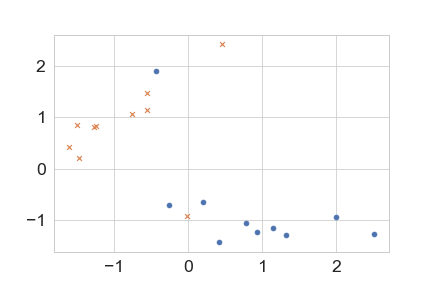

In [181]:
plt.scatter(X[Y==0,0],X[Y==0,1],marker='o')
plt.scatter(X[Y==1,0],X[Y==1,1],marker='x')


In [197]:
kernel = GPy.kern.RBF(input_dim=2,lengthscale=0.1,variance=1)
m = GPy.models.GPClassification(X,Y[:,np.newaxis],kernel=kernel)
m.optimize()

In [200]:
print(m)


Name : gp_classification
Objective : 9.538590515189838
Number of Parameters : 2
Number of Optimization Parameters : 2
Updates : True
Parameters:
  gp_classification.  |               value  |  constraints  |  priors
  rbf.variance        |  1.6595772955775334  |      +ve      |        
  rbf.lengthscale     |  1.6552196975408653  |      +ve      |        


In [198]:
x1s = np.linspace(-3, 3, 40)
x2s = np.linspace(-3, 3, 40)
X1, X2 = np.meshgrid(x1s, x2s)
Xtest = np.hstack([X1.flatten()[:,np.newaxis],X2.flatten()[:,np.newaxis]])
pred_probs = m.predict(Xtest)[0]
P = np.reshape(pred_probs,(len(x1s),len(x2s))) 

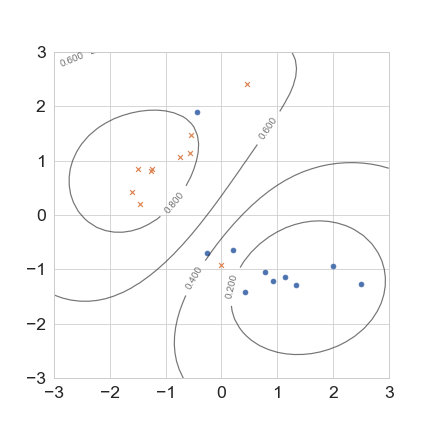

In [199]:
fig = plt.figure(figsize=(6,6))
ax = fig.gca()

#cfset = ax.contourf(X1, X2, P, levels=2,cmap='Greys')
cset = ax.contour(X1, X2, P, levels=4, colors='k',alpha=0.6)
ax.clabel(cset, inline=1, fontsize=10)
ax.scatter(X[Y==0,0],X[Y==0,1],marker='o')
ax.scatter(X[Y==1,0],X[Y==1,1],marker='x')

> Question: What happens for different values of the length-scale parameter

### A 1-D Example
We will now study the difference between EP and Laplace Approximation for a simple 1-D dataset.

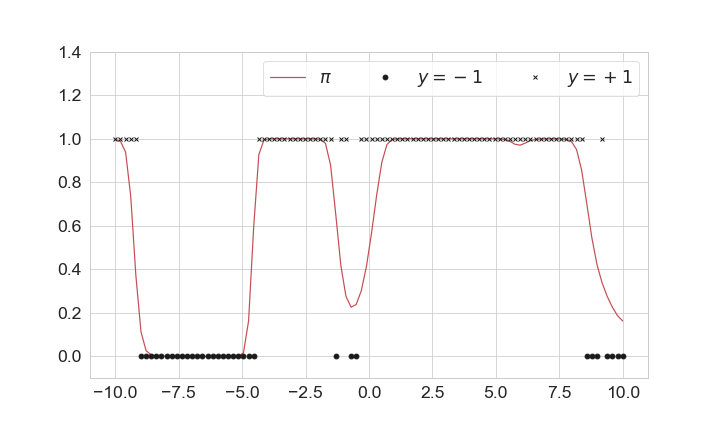

In [201]:
# first generate some data
kernel = GPy.kern.RBF(1, variance=7, lengthscale=1)
X = np.linspace(-10,10,100)[:,np.newaxis]
#draw the latent function value
f = np.random.multivariate_normal(np.zeros(100), kernel.K(X))
lik = GPy.likelihoods.Bernoulli()
p = lik.gp_link.transf(f) # squash the latent function
Y = lik.samples(f).reshape(-1,1)
fig = plt.figure(figsize=(10,6))
plt.plot(X,p,'r')
plt.plot(X[Y==0],Y[Y==0],'ko')
plt.plot(X[Y==1],Y[Y==1],'kx')
plt.ylim([-0.1,1.4])
plt.legend(['$\pi$','$y=-1$','$y=+1$'],ncol=3)
traininds = np.random.permutation(X.shape[0])[0:50]
Xtrain = X[traininds,:]
Ytrain = Y[traininds,:]

In [202]:
inf_method = GPy.inference.latent_function_inference.EP()
kernel = GPy.kern.RBF(input_dim=1,lengthscale=0.5,variance=1)
md_ep = GPy.models.GPClassification(Xtrain,Ytrain,
                                 kernel=kernel,
                                 inference_method = inf_method)
st = time.time()
md_ep.optimize('bfgs', max_iters=100)
en = time.time()
print('Optimization took {:.2f} seconds for EP'.format(en-st,inf_method))
print(md_ep)

Optimization took 0.05 seconds for EP

Name : gp_classification
Objective : 20.147395313101224
Number of Parameters : 2
Number of Optimization Parameters : 2
Updates : True
Parameters:
  gp_classification.  |               value  |  constraints  |  priors
  rbf.variance        |  2.6897053227713226  |      +ve      |        
  rbf.lengthscale     |  1.5917161786048464  |      +ve      |        


In [203]:
inf_method = GPy.inference.latent_function_inference.Laplace()
kernel = GPy.kern.RBF(input_dim=1,lengthscale=0.5,variance=1)
md_la = GPy.models.GPClassification(Xtrain,Ytrain,
                                 kernel=kernel,
                                 inference_method = inf_method)
st = time.time()
md_la.optimize('bfgs', max_iters=100)
en = time.time()
print('Optimization took {:.2f} seconds for Laplace'.format(en-st,inf_method))
print(md_la)

Optimization took 0.45 seconds for Laplace

Name : gp_classification
Objective : 17.455440789807724
Number of Parameters : 2
Number of Optimization Parameters : 2
Updates : True
Parameters:
  gp_classification.  |               value  |  constraints  |  priors
  rbf.variance        |  109.76737282247953  |      +ve      |        
  rbf.lengthscale     |  1.9808259632888814  |      +ve      |        


In [204]:
# get predictions
pred_probs_la = md_la.predict(X)[0]
pred_probs_ep = md_ep.predict(X)[0]

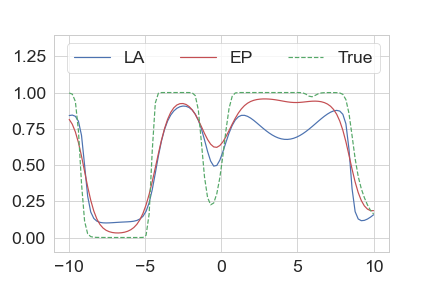

In [205]:
plt.plot(X,pred_probs_la,'b')
plt.plot(X,pred_probs_ep,'r')
plt.plot(X,p,'g--')
plt.ylim([-0.1,1.4])
plt.legend(['LA','EP','True'],ncol=3)